In [2]:
import numpy as np
import pandas as pd
import os
import gym
import time
import json
from copy import deepcopy

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, Add
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.callbacks import History
from keras.backend import tf as ktf
from keras.callbacks import Callback as KerasCallback, CallbackList as KerasCallbackList
from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger
from keras.utils.generic_utils import Progbar
from keras import backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, Policy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

from IPython import display
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# check our devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/nathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10677970854538156483
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 485490688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18208555497674664323
physical_device_desc: "device: 0, name: GeForce GTX 650, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [23]:
from gym import error, spaces

class Env(object):
    reward_range = (-np.inf, np.inf)
    action_space = spaces.Discrete(4)
    observation_space = spaces.Box(low=-1, high=1, shape=(3,3))

    def step(self, action):
        self.step_num += 1
        done = False
        previous_distance = abs(self.pos[0] - 2) + abs(self.pos[1] - 2)
        
        if action == 0:
            # up
            self.pos = (max(self.pos[0] - 1, 0), self.pos[1])
        if action == 1:
            # down
            self.pos = (min(self.pos[0] + 1, 2), self.pos[1])
        if action == 2:
            # left
            self.pos = (self.pos[0], max(self.pos[1] - 1, 0))
        if action == 3:
            # right
            self.pos = (self.pos[0], min(self.pos[1] + 1, 2))
            
        current_distance = abs(self.pos[0] - 2) + abs(self.pos[1] - 2)
        
        reward = -1.
        
        if previous_distance < current_distance:
            pass#reward = -1.
            
        if previous_distance > current_distance:
            reward = 1.
            
        if current_distance == 0:
            done = True
        
        self.observation = self.default_view.copy()
        self.observation[self.pos] = 0.5
        
        if self.step_num > 10:
            done= True
        
        return self.observation, reward, done, {}

    def reset(self):
        self.step_num = 0
        self.pos = (0,0)
        self.default_view = np.array([
            [0., 0., 0.],
            [0., 0., 0.],
            [0., 0., 1.]
        ])
        self.observation = self.default_view.copy()
        self.observation[self.pos] = 0.5
        return self.observation

    def render(self, mode='human', close=False):
        plt.imshow(self.observation)
        plt.show()
        
    
    def close(self):
        pass

    def seed(self, seed=None):
        pass

    def configure(self, *args, **kwargs):
        raise NotImplementedError()

    def __del__(self):
        self.close()

    def __str__(self):
        return '<{} instance>'.format(type(self).__name__)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [24]:
env = Env()
nb_actions = env.action_space.n

input_shape = (1, 3, 3)

frames_input = keras.layers.Input(input_shape, name='frames')

flat = keras.layers.Flatten()(frames_input)
hidden_1 = keras.layers.Dense(512, activation='relu')(flat)
hidden_2 = keras.layers.Dense(512, activation='relu')(hidden_1)
output = keras.layers.Dense(nb_actions)(hidden_2)

model = keras.models.Model(inputs=frames_input, outputs=output)
optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)

memory = SequentialMemory(limit=1000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 'eps', 1., 0., 0.0, 1000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=500, 
               target_model_update=1000, policy=policy, test_policy=policy)
dqn.compile(optimizer, metrics=['mse'])

In [25]:
# train the DQN
env.reset()
hist = dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)

Training for 5000 steps ...
Interval 1 (0 steps performed)
 4999/10000 [=============>................] - ETA: 1:03 - reward: 0.8364done, took 63.418 seconds


In [26]:
from rl.callbacks import (
    CallbackList,
    TestLogger,
    TrainEpisodeLogger,
    TrainIntervalLogger,
    Visualizer
)

class Visualizer(Visualizer):
    def on_episode_begin(self, episode, logs={}):
        self.env.render(mode='human')
        
    def on_action_end(self, action, logs):
        """ Render environment at the end of each action """
        self.env.render(mode='human')

def test(self, env, nb_episodes=1, action_repetition=1, callbacks=None, visualize=True,
         nb_max_episode_steps=None, nb_max_start_steps=0, start_step_policy=None, verbose=1):
    if not self.compiled:
        raise RuntimeError('Your tried to test your agent but it hasn\'t been compiled yet. Please call `compile()` before `test()`.')
    if action_repetition < 1:
        raise ValueError('action_repetition must be >= 1, is {}'.format(action_repetition))

    self.training = False
    self.step = 0

    callbacks = [] if not callbacks else callbacks[:]

    if verbose >= 1:
        callbacks += [TestLogger()]
    if visualize:
        callbacks += [Visualizer()]
    history = History()
    callbacks += [history]
    callbacks = CallbackList(callbacks)
    if hasattr(callbacks, 'set_model'):
        callbacks.set_model(self)
    else:
        callbacks._set_model(self)
    callbacks._set_env(env)
    params = {
        'nb_episodes': nb_episodes,
    }
    if hasattr(callbacks, 'set_params'):
        callbacks.set_params(params)
    else:
        callbacks._set_params(params)

    self._on_test_begin()
    callbacks.on_train_begin()
    for episode in range(nb_episodes):
        callbacks.on_episode_begin(episode)
        episode_reward = 0.
        episode_step = 0

        # Obtain the initial observation by resetting the environment.
        self.reset_states()
        observation = deepcopy(env.reset())
        if self.processor is not None:
            observation = self.processor.process_observation(observation)
        assert observation is not None

        # Perform random starts at beginning of episode and do not record them into the experience.
        # This slightly changes the start position between games.
        nb_random_start_steps = 0 if nb_max_start_steps == 0 else np.random.randint(nb_max_start_steps)
        for _ in range(nb_random_start_steps):
            if start_step_policy is None:
                action = env.action_space.sample()
            else:
                action = start_step_policy(observation)
            if self.processor is not None:
                action = self.processor.process_action(action)
            callbacks.on_action_begin(action)
            observation, r, done, info = env.step(action)
            observation = deepcopy(observation)
            if self.processor is not None:
                observation, r, done, info = self.processor.process_step(observation, r, done, info)
            callbacks.on_action_end(action)
            if done:
                warnings.warn('Env ended before {} random steps could be performed at the start. You should probably lower the `nb_max_start_steps` parameter.'.format(nb_random_start_steps))
                observation = deepcopy(env.reset())
                if self.processor is not None:
                    observation = self.processor.process_observation(observation)
                break

        # Run the episode until we're done.
        done = False
        while not done:
            callbacks.on_step_begin(episode_step)

            action = self.forward(observation)
            q_values = self.compute_q_values(np.array([observation]))
            print("Q:", q_values)
            if self.processor is not None:
                action = self.processor.process_action(action)
            reward = 0.
            accumulated_info = {}
            for _ in range(action_repetition):
                callbacks.on_action_begin(action)
                observation, r, d, info = env.step(action)
                observation = deepcopy(observation)
                if self.processor is not None:
                    observation, r, d, info = self.processor.process_step(observation, r, d, info)
                callbacks.on_action_end(action)
                reward += r
                for key, value in info.items():
                    if not np.isreal(value):
                        continue
                    if key not in accumulated_info:
                        accumulated_info[key] = np.zeros_like(value)
                    accumulated_info[key] += value
                if d:
                    done = True
                    break
            if nb_max_episode_steps and episode_step >= nb_max_episode_steps - 1:
                done = True
            self.backward(reward, terminal=done)
            episode_reward += reward

            step_logs = {
                'action': action,
                'observation': observation,
                'reward': reward,
                'episode': episode,
                'info': accumulated_info,
            }
            callbacks.on_step_end(episode_step, step_logs)
            episode_step += 1
            self.step += 1

        # We are in a terminal state but the agent hasn't yet seen it. We therefore
        # perform one more forward-backward call and simply ignore the action before
        # resetting the environment. We need to pass in `terminal=False` here since
        # the *next* state, that is the state of the newly reset environment, is
        # always non-terminal by convention.
        self.forward(observation)
        self.backward(0., terminal=False)

        # Report end of episode.
        episode_logs = {
            'episode_reward': episode_reward,
            'nb_steps': episode_step,
        }
        callbacks.on_episode_end(episode, episode_logs)
    callbacks.on_train_end()
    self._on_test_end()

    return history


Testing for 1 episodes ...


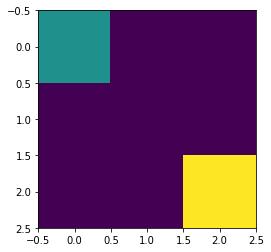

Q: [-0.26789325  2.6096675  -0.32798812  3.7045968 ]


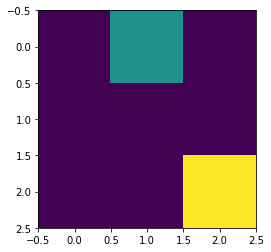

Q: [-0.25252905  3.1903093  -0.32743663  2.5436535 ]


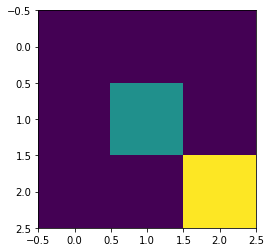

Q: [-0.21702978  1.9802551  -0.2900339   1.9839945 ]


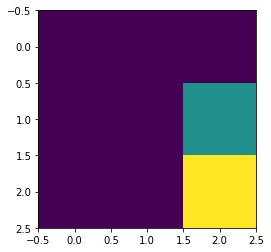

Q: [-0.22953087  0.99759996 -0.28926942  0.5862225 ]


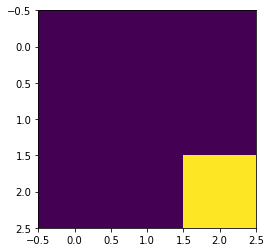

Episode 1: reward: 4.000, steps: 4


In [27]:
# test the DQN
env.reset()
test(dqn, env, nb_episodes=1, callbacks=[], visualize=True)